# Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

csv = 'HR_comma_sep.csv'

# Extract data from CSV

In [4]:
data = pd.read_csv(csv)
print(data.columns)
print(data.head())

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')
   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years  sales  \
0                   3              0     1                      0  sales   
1                   6              0     1                      0  sales   
2                   4              0     1                      0  sales 

# Clean data in columns

In [5]:
data['satisfaction_level'] = data['satisfaction_level'].fillna(data['satisfaction_level'].mean())
data['last_evaluation'] = data['last_evaluation'].fillna(data['last_evaluation'].mean())
data['number_project'] = data['number_project'].fillna(data['number_project'].median())
data['average_montly_hours'] = data['average_montly_hours'].fillna(data['average_montly_hours'].median())
data['time_spend_company'] = data['time_spend_company'].fillna(data['time_spend_company'].median())
data['Work_accident'] = data['Work_accident'].fillna(data['Work_accident'].median())
data['promotion_last_5years'] = data['promotion_last_5years'].fillna(data['promotion_last_5years'].median())
data['salary'] = data['salary'].fillna('low')
data['left'] = data['left'].fillna(data['left'].median())


# Correlation Heatmap

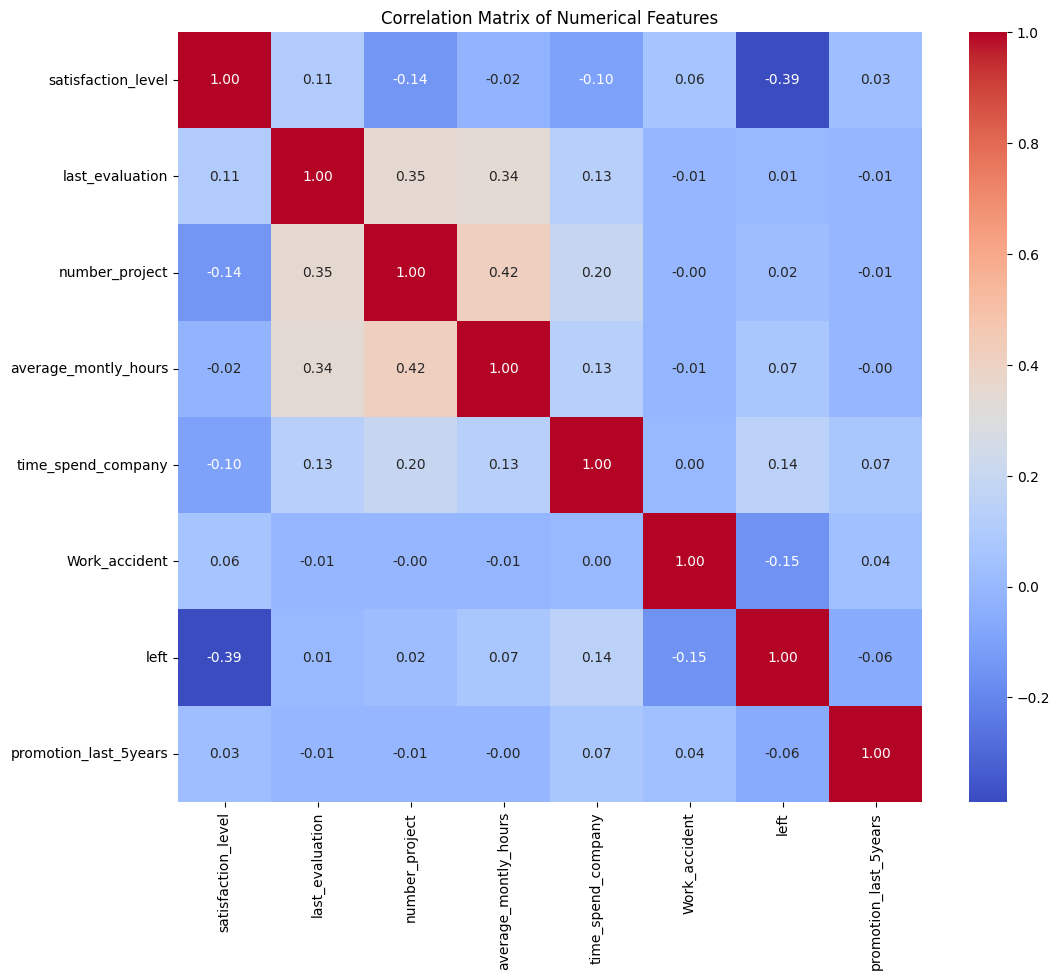

In [6]:
rm = data.copy(deep=True)
rm.drop(['sales', 'salary'], axis=1, inplace=True)
corr_matrix = rm.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Distribution Plots

<Figure size 1500x500 with 0 Axes>

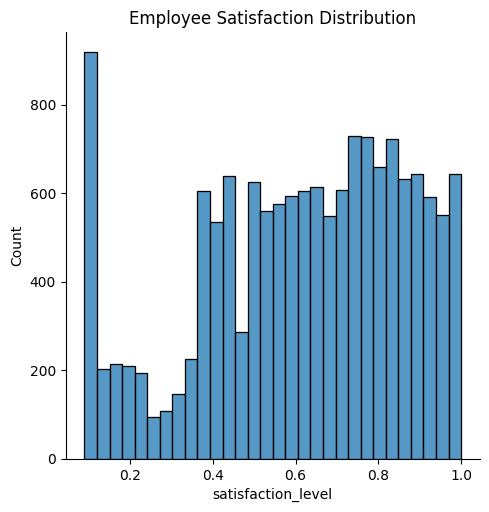

In [7]:
plt.figure(figsize=(15, 5))
sns.displot(data['satisfaction_level'])
plt.title('Employee Satisfaction Distribution')
plt.show()

<Figure size 1500x500 with 0 Axes>

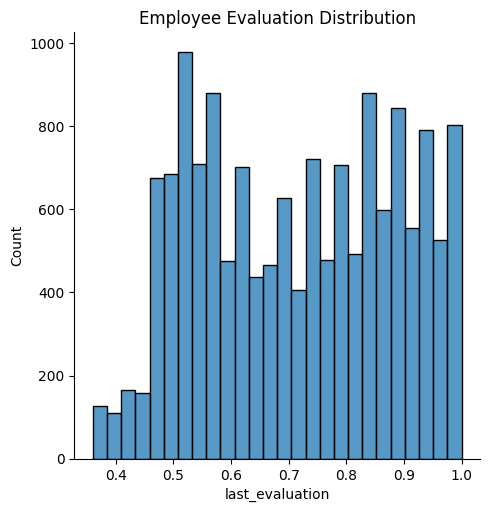

In [8]:
plt.figure(figsize=(15, 5))
sns.displot(data['last_evaluation'])
plt.title('Employee Evaluation Distribution')
plt.show()

<Figure size 1500x500 with 0 Axes>

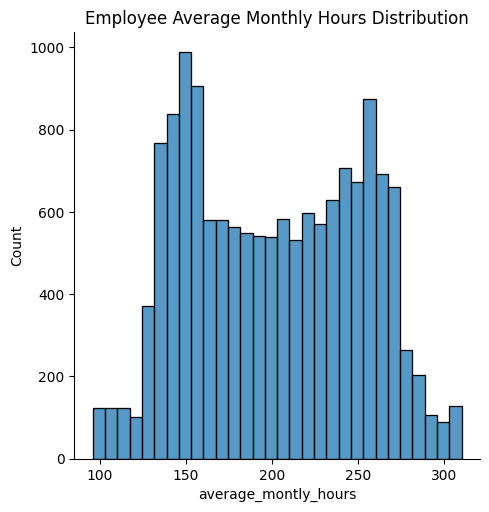

In [9]:
plt.figure(figsize=(15, 5))
sns.displot(data['average_montly_hours'])
plt.title('Employee Average Monthly Hours Distribution')
plt.show()


# Bar plot

Inference: Employees not involved enough in projects lose interest and leave the company. This is based off the fact that there is a high number of employees which left after 2 projects.

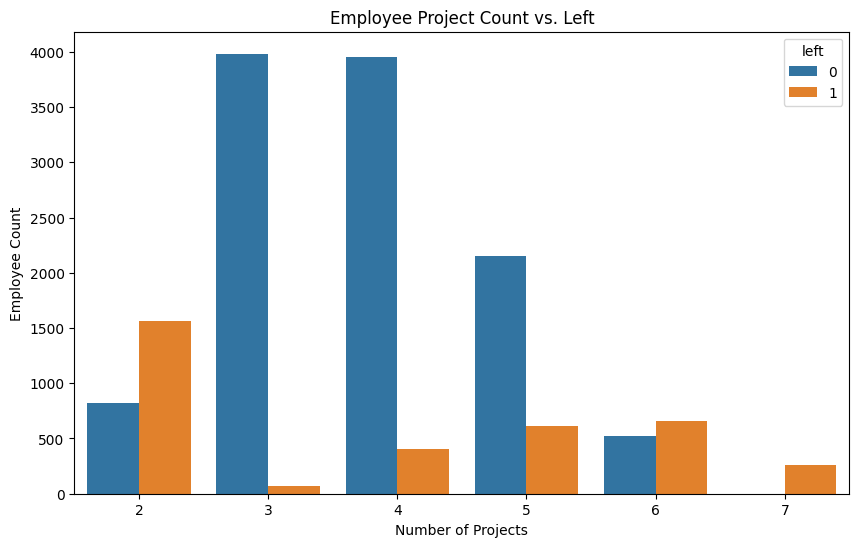

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x='number_project', hue='left', data=data)
plt.title('Employee Project Count vs. Left')
plt.xlabel('Number of Projects')
plt.ylabel('Employee Count')
plt.show()

# Clustering

In [11]:
kmeandata = data.copy(deep=True)
kmeandata.drop(['number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 'sales', 'salary'], axis=1, inplace=True)
kmean = KMeans(n_clusters=3)
kmean.fit(kmeandata)
data['cluster'] = kmean.labels_

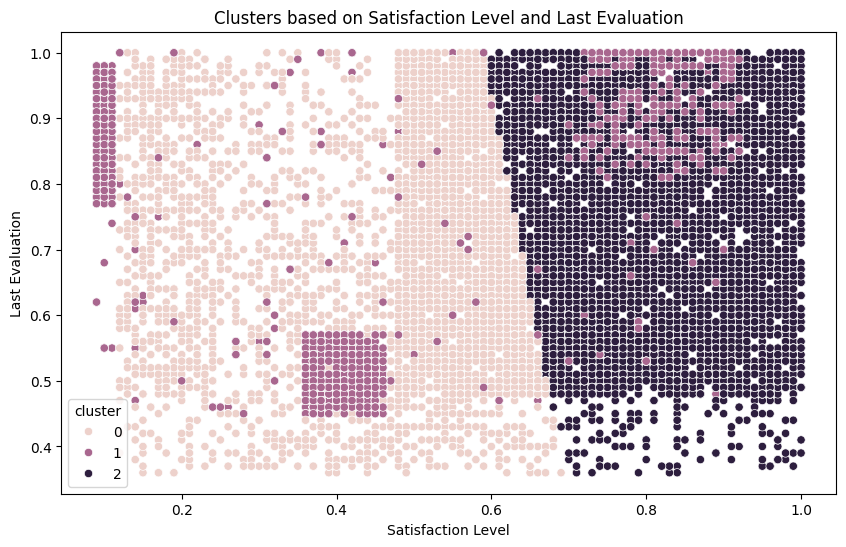

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='satisfaction_level', y='last_evaluation', hue='cluster', data=data)
plt.title('Clusters based on Satisfaction Level and Last Evaluation')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.show()

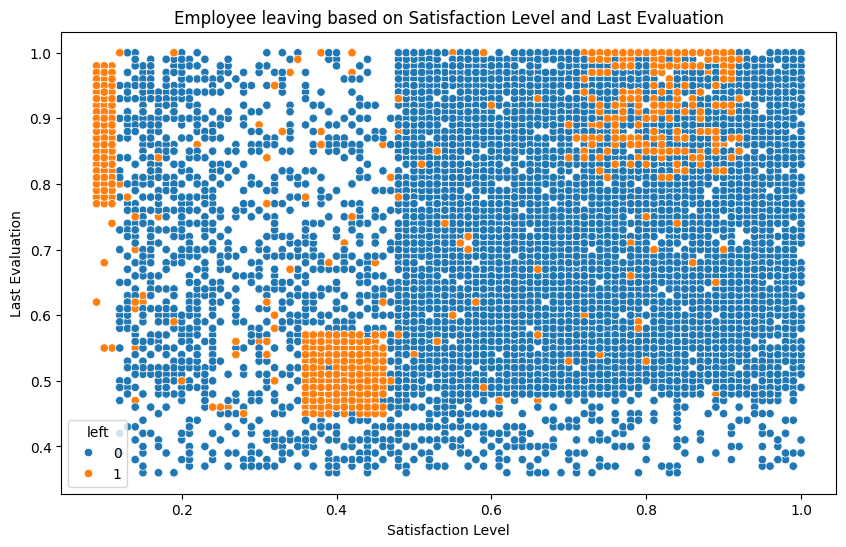

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='satisfaction_level', y='last_evaluation', hue='left', data=data)
plt.title('Employee leaving based on Satisfaction Level and Last Evaluation')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.show()

# Applying SMOTE to data

In [14]:
categorical_cols = ['sales', 'salary']
numerical_cols = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours',
                  'time_spend_company', 'Work_accident', 'promotion_last_5years', 'left']

categorical_data = data[categorical_cols]
numerical_data = data[numerical_cols]

categorical_data = pd.get_dummies(categorical_data, drop_first=True)

processed_data = pd.concat([numerical_data, categorical_data], axis=1)


In [15]:
X = processed_data.drop('left', axis=1)
y = processed_data['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11999, 18) (3000, 18) (11999,) (3000,)


In [16]:
smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(X_train_smote.shape, y_train_smote.shape)


(18284, 18) (18284,)


# Classification

In [17]:
logreg = LogisticRegression(max_iter=1000)  # Increased max_iter
y_pred_logreg = cross_val_predict(logreg, X_train_smote, y_train_smote, cv=5)
print("Logistic Regression Classification Report:")
print(classification_report(y_train_smote, y_pred_logreg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      9142
           1       0.78      0.82      0.80      9142

    accuracy                           0.80     18284
   macro avg       0.80      0.80      0.79     18284
weighted avg       0.80      0.80      0.79     18284



In [18]:
rf_clf = RandomForestClassifier(random_state=123)
y_pred_rf = cross_val_predict(rf_clf, X_train_smote, y_train_smote, cv=5)
print("Random Forest Classification Report:")
print(classification_report(y_train_smote, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9142
           1       1.00      0.97      0.98      9142

    accuracy                           0.98     18284
   macro avg       0.98      0.98      0.98     18284
weighted avg       0.98      0.98      0.98     18284



In [19]:
gb_clf = GradientBoostingClassifier(random_state=123)
y_pred_gb = cross_val_predict(gb_clf, X_train_smote, y_train_smote, cv=5)
print("Gradient Boosting Classification Report:")
print(classification_report(y_train_smote, y_pred_gb))

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      9142
           1       0.98      0.95      0.96      9142

    accuracy                           0.96     18284
   macro avg       0.96      0.96      0.96     18284
weighted avg       0.96      0.96      0.96     18284



# Plot AUC/ROC

In [20]:
logreg.fit(X_train_smote, y_train_smote)
rf_clf.fit(X_train_smote, y_train_smote)
gb_clf.fit(X_train_smote, y_train_smote)
y_pred_logreg_test = logreg.predict(X_test)
y_pred_rf_test = rf_clf.predict(X_test)
y_pred_gb_test = gb_clf.predict(X_test)

In [21]:
lr_auc = roc_auc_score(y_test, y_pred_logreg_test)
rf_auc = roc_auc_score(y_test, y_pred_rf_test)
gbc_auc = roc_auc_score(y_test, y_pred_gb_test)

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_test, gb_clf.predict_proba(X_test)[:,1])

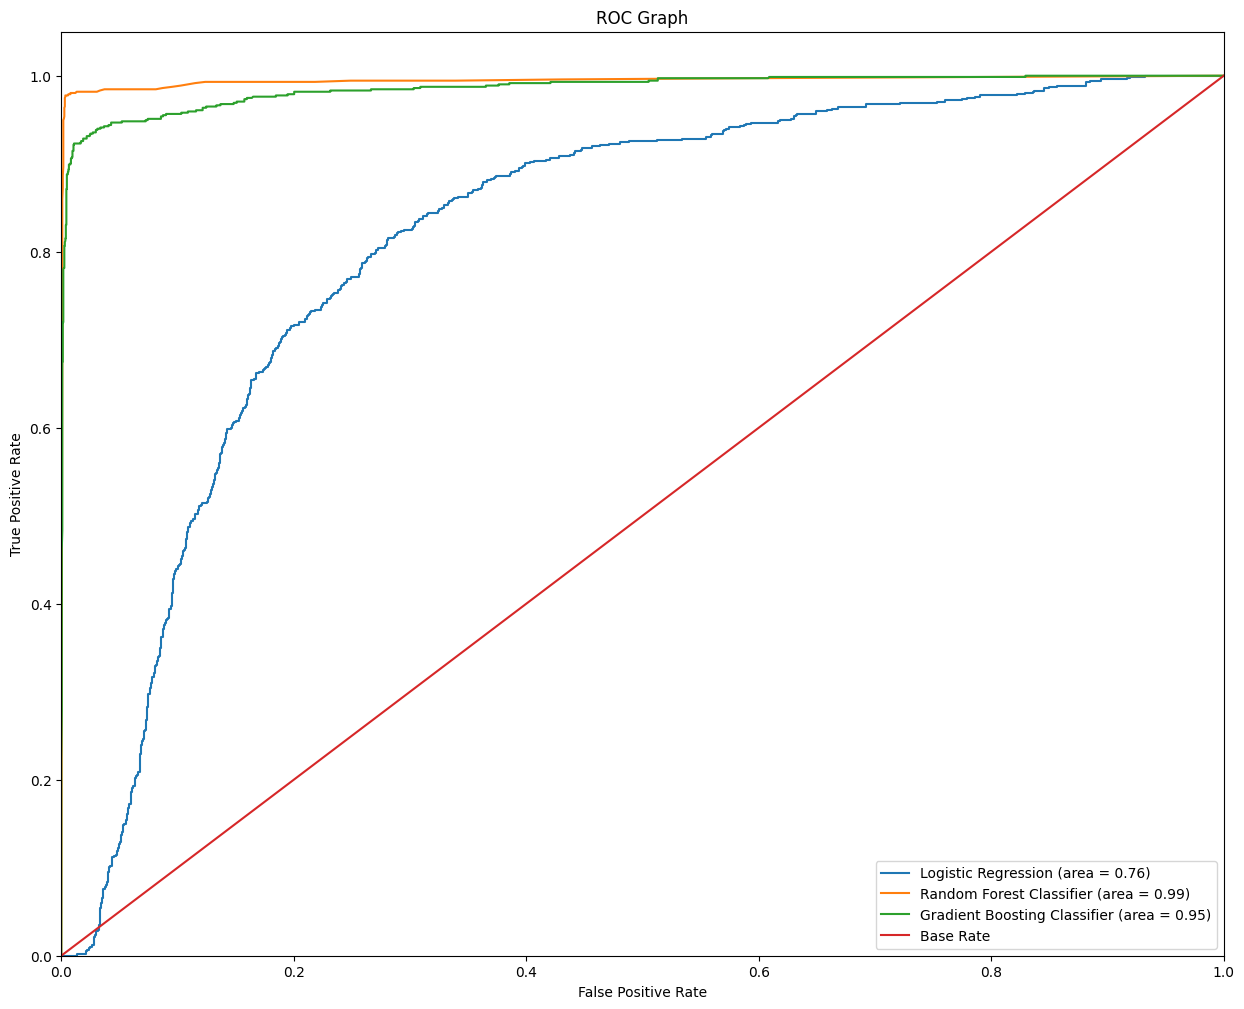

In [ ]:
plt.figure(figsize=(15,12))

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lr_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (area = %0.2f)' % rf_auc)

# Plot Decision Tree ROC
plt.plot(gbc_fpr, gbc_tpr, label='Gradient Boosting Classifier (area = %0.2f)' % gbc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrices
For the confusion matrices, false positives are more prevalent than false negatives, so precision should be prioritized over recall.

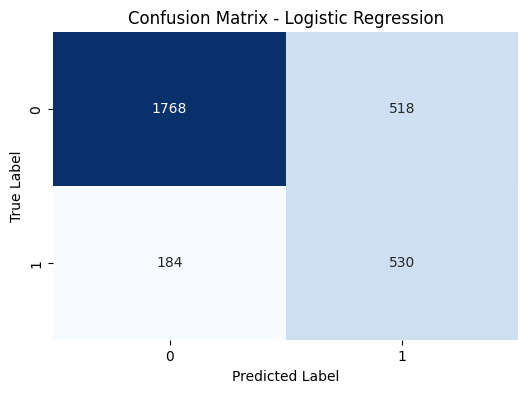

In [24]:
cm = confusion_matrix(y_test, y_pred_logreg_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

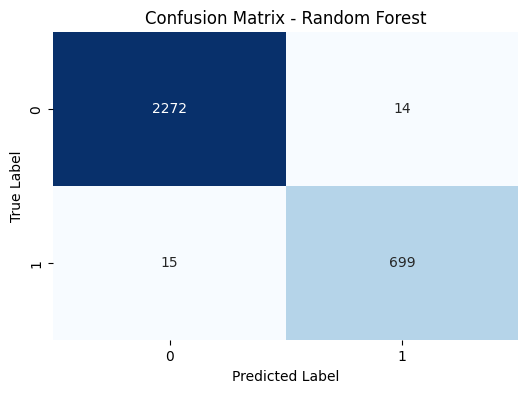

In [25]:
cm = confusion_matrix(y_test, y_pred_rf_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


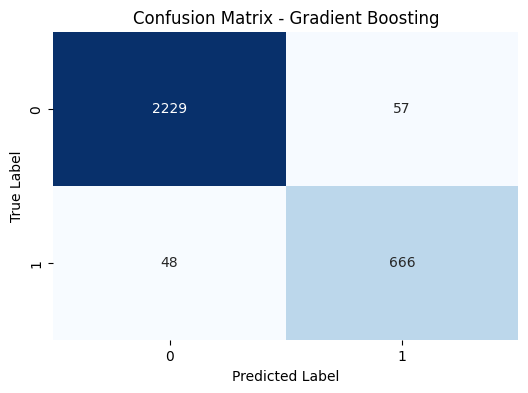

In [26]:
cm = confusion_matrix(y_test, y_pred_gb_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Distribution of Employees at risk of leaving

In [27]:
y_pred_proba_rf = rf_clf.predict_proba(X_test)
turnover_probabilities = y_pred_proba_rf[:, 1]
turnover_probabilities

array([0.  , 0.55, 0.05, ..., 0.01, 0.02, 1.  ], shape=(3000,))

In [28]:
zones = []
for score in turnover_probabilities:
    if score < 0.2:
        zones.append("Safe Zone (Green)")
    elif 0.2 <= score < 0.6:
        zones.append("Low-Risk Zone (Yellow)")
    elif 0.6 <= score < 0.9:
        zones.append("Medium-Risk Zone (Orange)")
    else:
        zones.append("High-Risk Zone (Red)")
employee_zones = pd.Series(zones)


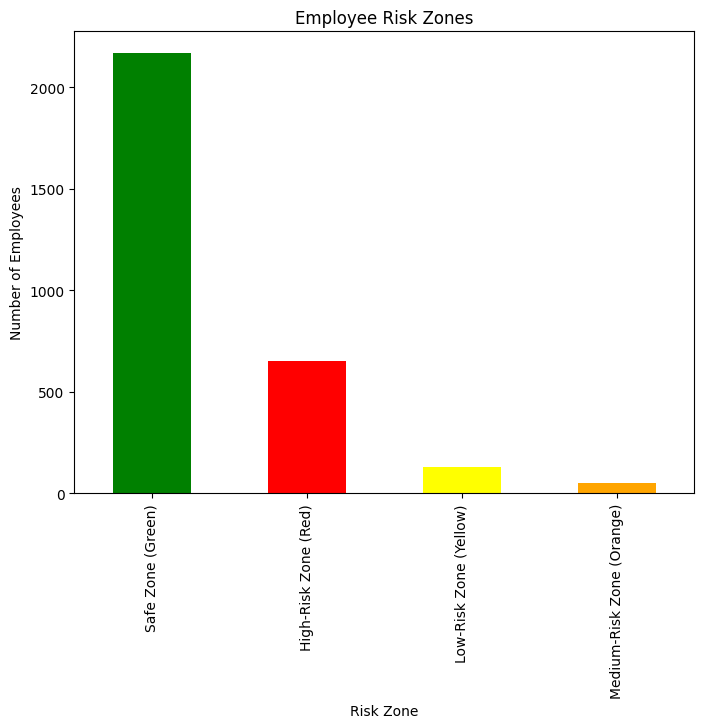

In [29]:
plt.figure(figsize=(8, 6))
employee_zones.value_counts().plot(kind='bar', color=['green', 'red', 'yellow', 'orange'])
plt.title('Employee Risk Zones')
plt.xlabel('Risk Zone')
plt.ylabel('Number of Employees')
plt.show()
